In [44]:
from sklearn .datasets import load_digits
digits=load_digits ()
print(digits.keys())
data = digits ["data"]
images = digits ["images"]
target = digits ["target"]
target_names = digits ["target_names"]


dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [41]:
import numpy as np
import matplotlib.pyplot as plt

Image shape: (8, 8)


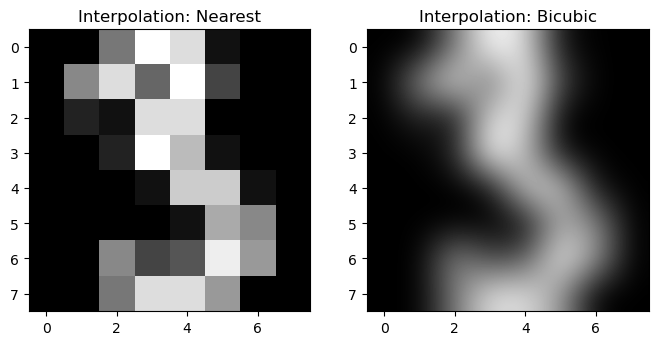

In [4]:
index = np.where(target == 3)[0][0]
image_data = images[index]
image_shape = image_data.shape
print(f"Image shape: {image_shape}")
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image_data, cmap='gray', interpolation='nearest')
plt.title("Interpolation: Nearest")
plt.subplot(1, 2, 2)
plt.imshow(image_data, cmap='gray', interpolation='bicubic')
plt.title("Interpolation: Bicubic")
plt.show()

In [5]:
from sklearn import model_selection
mask = (target == 3) | (target == 9)
X_all = data[mask]
y_all = target[mask]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_all, y_all, test_size=0.4, random_state=0
)


In [17]:
import numpy as np
def compute_average_image(X, y, target):
    return np.mean(X[y == target], axis=0)

def features2d(X, y):

    avg_image_3 = compute_average_image(X, y, 3)
    avg_image_9 = compute_average_image(X, y, 9)

    diff = np.abs(avg_image_3 - avg_image_9)
    pixel_1, pixel_2 = np.argsort(diff)[-2:]

    features = X[:, [pixel_1, pixel_2]]
    return features

X_train_2d = features2d(X_train, y_train)
X_test_2d = features2d(X_test, y_test)

mean_3 = compute_average_image(X_train, y_train, 3)
mean_9 = compute_average_image(X_train, y_train, 9)


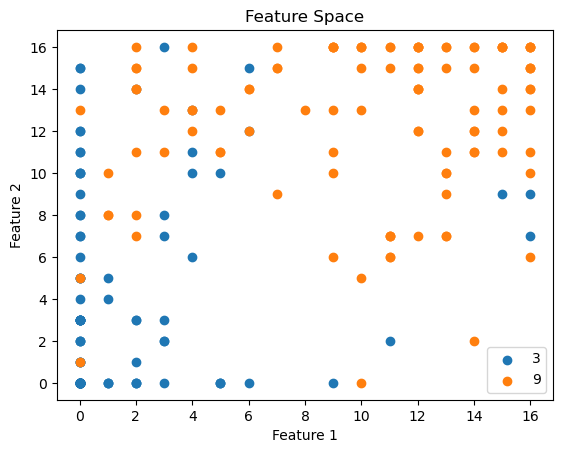

In [18]:
import matplotlib.pyplot as plt

def plot_features(X, y):

    for target in [3, 9]:
        mask = (y == target)
        plt.scatter(X[mask, 0], X[mask, 1], label=str(target))
    
    plt.title('Feature Space')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    
    plt.legend()
    
    plt.show()

plot_features(X_train_2d, y_train)


In [19]:
from sklearn.svm import SVC

clf = SVC(kernel='rbf', random_state=42)

y_train_binary = np.where(y_train == 3, -1, 1)
y_test_binary = np.where(y_test == 3, -1, 1)

clf.fit(X_train_2d, y_train_binary)

y_train_pred = clf.predict(X_train_2d)
y_test_pred = clf.predict(X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')


Training error: 0.10
Test error: 0.10


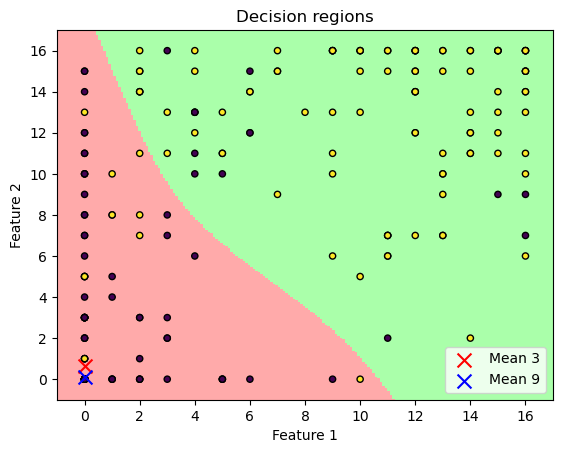

In [20]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_binary, edgecolor='k', s=20)
plt.scatter(mean_3[0], mean_3[1], marker='x', color='red', s=100, label='Mean 3')
plt.scatter(mean_9[0], mean_9[1], marker='x', color='blue', s=100, label='Mean 9')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Decision regions")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['3', '9'])
plt.legend()
plt.show()


In [23]:
def fit_lda(training_features, training_labels):

    mu = np.array([compute_average_image(training_features, training_labels, i) for i in [-1, 1]])

    covmat = np.cov(training_features.T)

    p = np.array([np.mean(training_labels == i) for i in [-1, 1]])

    return mu, covmat, p

variances = np.var(X_all, axis=0)
mask = variances > 0.001
X_all_filtered = X_all[:, mask]

mu_2d, covmat_2d, p_2d = fit_lda(X_train_2d, y_train_binary)
mu_all, covmat_all, p_all = fit_lda(X_all_filtered, y_all)


In [24]:
def predict_lda(mu, covmat, p, test_features):

    inv_covmat = np.linalg.inv(covmat)

    beta = inv_covmat @ (mu[1] - mu[0]).T
    b = -0.5 * (mu[1] + mu[0]) @ beta + np.log(p[1]/p[0])

    predicted_labels = np.sign(test_features @ beta + b)
    
    return predicted_labels

y_train_pred = predict_lda(mu_2d, covmat_2d, p_2d, X_train_2d)
y_test_pred = predict_lda(mu_2d, covmat_2d, p_2d, X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')


Training error: 0.11
Test error: 0.10


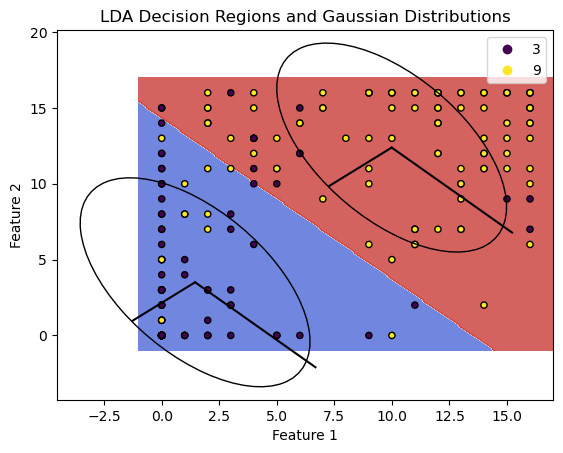

Training error: 0.11
Test error: 0.10
Percentage of training data points in the correct decision region: 89.40%
Percentage of test data points in the correct decision region: 90.41%


In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

eigvals, eigvecs = np.linalg.eig(covmat_2d)

std_devs = np.sqrt(eigvals)

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

Z = predict_lda(mu_2d, covmat_2d, p_2d, np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure()
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.8)

scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train_binary, edgecolor='k', s=20)

for i, mu in enumerate(mu_2d):
    angle = np.rad2deg(np.arccos(eigvecs[0, 0]))
    ellipse = Ellipse((mu[0], mu[1]), std_devs[0]*2, std_devs[1]*2,angle=30,edgecolor='k', fc='none')
    plt.gca().add_patch(ellipse)

for i, mu in enumerate(mu_2d):
    for j in range(2):
        plt.plot([mu[0], mu[0] + std_devs[j]*eigvecs[j, 0]],
                 [mu[1], mu[1] + std_devs[j]*eigvecs[j, 1]], 'k')

plt.title("LDA Decision Regions and Gaussian Distributions")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['3', '9'])
plt.show()

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')

if train_error < test_error:
    print("The model may be overfitting.")

if train_error > 0.5 and test_error > 0.5:
    print("The model may be underfitting.")

correct_train = np.sum(y_train_binary == y_train_pred) / len(y_train_binary)
correct_test = np.sum(y_test_binary == y_test_pred) / len(y_test_binary)

print(f'Percentage of training data points in the correct decision region: {correct_train*100:.2f}%')
print(f'Percentage of test data points in the correct decision region: {correct_test*100:.2f}%')



In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()

mask = (target == 3) | (target == 9)
X_all = data[mask]
y_all_binary = np.where(target[mask] == 3, -1, 1)

scores = cross_val_score(lda, X_all, y_all_binary, cv=10)

print(f'LDA 10-fold cross-validation mean accuracy: {scores.mean():.2f}, std: {scores.std():.2f}')


LDA 10-fold cross-validation mean accuracy: 0.98, std: 0.03


Training error: 1.00
Test error: 1.00


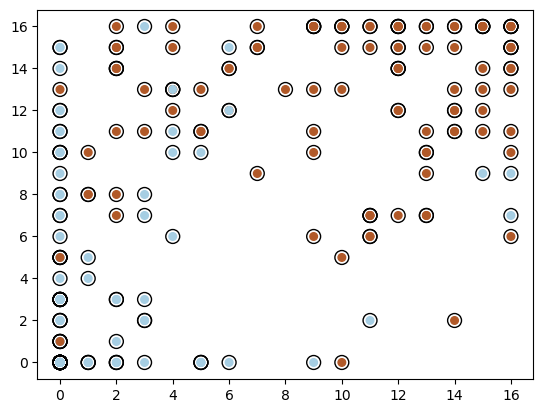

In [84]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def loss(params, X, y, lambda_):
    beta = params[:-1]
    b = params[-1]
    regularization = 0.5 * np.dot(beta, beta)
    data_term = lambda_ * np.mean(relu(1 - y * (np.dot(X, beta) + b)))
    return regularization + data_term

def gradient(params, X, y, lambda_):
    beta = params[:-1]
    b = params[-1]
    N = len(y)
    mask = y * (np.dot(X, beta) + b) < 1
    d_beta = beta - lambda_ / N * np.sum(-y[mask, None] * X[mask], axis=0)
    d_b = -lambda_ / N * np.sum(y[mask])
    return np.append(d_beta, d_b)

def fit_svm(X, y, lambda_):
    params0 = np.zeros(X.shape[1] + 1)
    result = minimize(loss, params0, args=(X, y, lambda_), jac=gradient)
    return result.x[:-1], result.x[-1]

def predict_svm(beta, b, X):
    return np.sign(np.dot(X, beta) + b)

def plot_decision_boundary(beta, b, X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = predict_svm(beta, b, xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], s=100,
               facecolors='none', edgecolors='k')
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=100,
               facecolors='none', edgecolors='k')
    plt.show()

beta,b = fit_svm(X_train_2d, y_train_binary, lambda_=0.5)
y_train_pred = predict_svm(beta, b, X_train_2d)
y_test_pred = predict_svm(beta, b, X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')

plot_decision_boundary(beta, b, X_train_2d, y_train_binary)


Training error: 0.32
Test error: 0.36


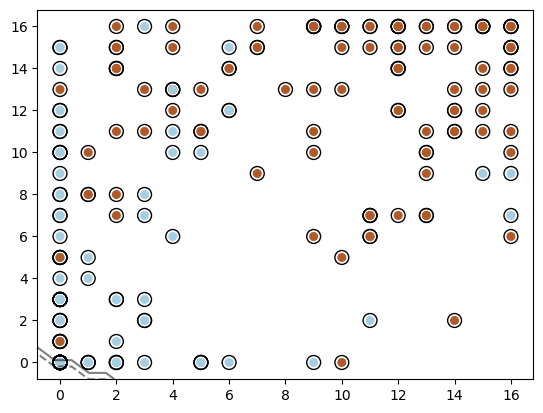

In [91]:
import numpy as np

def gradient_descent(X, y, lambda_, tau, num_iter):
    N, d = X.shape
    beta = np.random.normal(0, 1, d)
    b = 0

    for t in range(num_iter):
        mask = y * (np.dot(X, beta) + b) < 1
        d_beta = beta - lambda_ / N * np.sum(-y[mask, None] * X[mask], axis=0)
        d_b = -lambda_ / N * np.sum(y[mask])
        
        beta = beta - tau * d_beta
        b = b - tau * d_b

    return beta, b

beta, b = gradient_descent(X_train_2d, y_train_binary, lambda_=1, tau=0.01, num_iter=100)
y_train_pred = predict_svm(beta, b, X_train_2d)
y_test_pred = predict_svm(beta, b, X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')

plot_decision_boundary(beta, b, X_train_2d, y_train_binary)


Training error: 0.27
Test error: 0.19
Best λ: 0.5
Training error: 0.10
Test error: 0.10


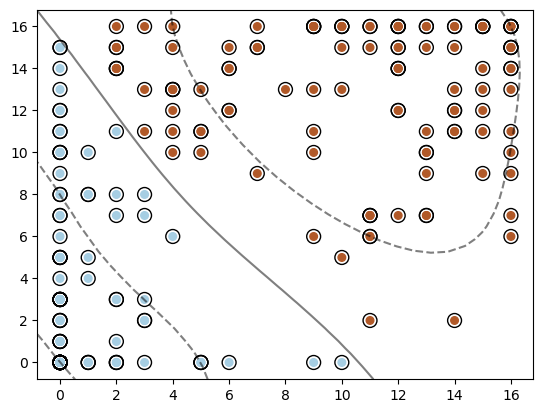

In [120]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import svm

def relu(x):
    return np.maximum(0, x)

def loss(params, X, y, lambda_):
    beta = params[:-1]
    b = params[-1]
    regularization = 0.5 * np.dot(beta, beta)
    data_term = lambda_ * np.mean(relu(1 - y * (np.dot(X, beta) + b)))
    return regularization + data_term

def gradient(params, X, y, lambda_):
    beta = params[:-1]
    b = params[-1]
    N = len(y)
    mask = y * (np.dot(X, beta) + b) < 1
    d_beta = beta - lambda_ / N * np.sum(-y[mask, None] * X[mask], axis=0)
    d_b = -lambda_ / N * np.sum(y[mask])
    return np.append(d_beta, d_b)

def fit_svm(X, y, lambda_, tau, num_iter):
    N, d = X.shape
    beta = np.random.normal(0, 1, d)
    b = 0
    losses = []
    errors = []

    for t in range(num_iter):
        mask = y * (np.dot(X, beta) + b) < 1
        d_beta = beta - lambda_ / N * np.sum(-y[mask, None] * X[mask], axis=0)
        d_b = -lambda_ / N * np.sum(y[mask])
        
        beta = beta - tau * d_beta
        b = b - tau * d_b

        loss_value = loss(np.append(beta, b), X, y, lambda_)
        losses.append(loss_value)
        error = np.mean(y != predict_svm(beta, b, X))
        errors.append(error)

        if t > 1 and errors[-2] - errors[-1] < 1e-5:
            tau /= 10

    return beta, b, losses, errors

def predict_svm(beta, b, X):
    return np.sign(np.dot(X, beta) + b)

def plot_decision_boundary(clf, X, y, pred):
    plt.scatter(X[:, 0], X[:, 1], c=pred, s=30, cmap=plt.cm.Paired)

    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], s=100,
               facecolors='none', edgecolors='k')
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], s=100,
               facecolors='none', edgecolors='k')
    plt.show()

beta, b, losses, errors = fit_svm(X_train_2d, y_train_binary, lambda_=0.5, tau=0.01, num_iter=5000)
y_train_pred = predict_svm(beta, b, X_train_2d)
y_test_pred = predict_svm(beta, b, X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')

param_grid = {'C': [0.1, 0.25, 0.5, 0.75,1]}

grid = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=5)
grid.fit(X_train_2d, y_train_binary)

print(f'Best λ: {grid.best_params_["C"]}')

clf = grid.best_estimator_
y_train_pred = clf.predict(X_train_2d)
y_test_pred = clf.predict(X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Training error: {train_error:.2f}')
print(f'Test error: {test_error:.2f}')

plot_decision_boundary(clf, X_train_2d, y_train_binary, y_train_pred)


In [119]:
from sklearn import svm
from sklearn.metrics import accuracy_score

beta, b, losses, errors = fit_svm(X_train_2d, y_train_binary, lambda_=1, tau=0.01, num_iter=1000)
y_train_pred = predict_svm(beta, b, X_train_2d)
y_test_pred = predict_svm(beta, b, X_test_2d)

train_error = np.mean(y_train_binary != y_train_pred)
test_error = np.mean(y_test_binary != y_test_pred)

print(f'Custom SVM - Training error: {train_error:.2f}')
print(f'Custom SVM - Test error: {test_error:.2f}')

clf_sklearn = svm.LinearSVC(dual=False, max_iter=5000)
clf_sklearn.fit(X_train_2d, y_train_binary)

y_train_pred_sklearn = clf_sklearn.predict(X_train_2d)
y_test_pred_sklearn = clf_sklearn.predict(X_test_2d)

train_error_sklearn = np.mean(y_train_binary != y_train_pred_sklearn)
test_error_sklearn = np.mean(y_test_binary != y_test_pred_sklearn)

print(f'sklearn SVM - Training error: {train_error_sklearn:.2f}')
print(f'sklearn SVM - Test error: {test_error_sklearn:.2f}')



Custom SVM - Training error: 0.71
Custom SVM - Test error: 0.73
sklearn SVM - Training error: 0.11
sklearn SVM - Test error: 0.09


In [ ]:
#SVM is a powerful classification and regression method that classifies data points into different categories by finding the optimal segmentation surface (or hyperplane). 
#The core idea of SVM is to find a simple model by minimizing a complex optimization problem. 
#SVMs can handle nonlinear problems by using different kernel functions, which allows SVMs to handle complex datasets. The core assumption of SVM is that in a high-dimensional space, data points can be separated by a linearly separable hyperplane. 
#By mapping data to a high-dimensional space, SVMs can handle nonlinear problems.
#LDA is a supervised method of dimensionality reduction that requires category information. 
#It can minimize the difference between categories while reducing the dimensionality. 
#The goal of LDA is to make the distance between samples of different classes as large as possible in the new low-dimensional space, and the distance between samples of the same kind is as small as possible. 
#Unlike SVM, LDA can not only reduce dimensionality, but can also be used in classification tasks.
#The nearest average classifier is a distance metric-based classification method whose prediction quality depends on the distribution of the data and the degree of overlap of the categories.
#Overall, the variation in prediction quality of SVM, LDA, and the nearest average classifier depends on a number of factors, including the nature of the data, the needs of the task, and the complexity of the model. 
#In practical applications, we need to select an appropriate model according to the task requirements and data characteristics, and evaluate the model performance by drawing ROC curves and other methods. 
#In this way, we can find the best model for our data and tasks to get the best prediction quality.